In [2]:
# %load exploratory_behavior_2hand.py


#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 13 11:53:01 2018

@author: stiso
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# read data
top_dir = '/Users/stiso/Documents/Python/graphLearning/ECoG data/'
subj = '4'
HUPID = '191'
ext = ''
data_raw = pd.read_csv("".join((top_dir, 'behavioral_data_raw/HUP', HUPID, '_typingtask/subj', subj, '_log_motor_run1', ext, '.csv')))
save_dir = "".join((top_dir, 'behavioral_data_raw/subj', subj, '/'))
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
data = data_raw
data["graph"][1]

'modular'

In [3]:
# add block
data['block'] = data['trialNum']
for index, row in data.iterrows():
    if row['trialNum'] < 251:
        data.loc[index,'block'] = 1
    elif row['trialNum'] > 250 and row['trialNum'] < 501:
        data.loc[index,'block'] = 2
    elif row['trialNum'] > 500 and row['trialNum'] < 751:
        data.loc[index,'block'] = 3
    elif row['trialNum'] > 750:
        data.loc[index,'block'] = 4
           
data.tail()

,sess,graph,trialNum,resp,path,pID,walk,ISI_raw,correct_raw,onset_raw,resp_raw,rt_raw,typing_raw,order,block
998,1,modular,999.0,b,img/target_6.png,4.0,8.0,0.05,1.0,722.262390,['b'],0.446618,a,998.0,4.0
999,1,modular,1000.0,v,img/target_5.png,4.0,6.0,0.05,1.0,722.796875,['v'],0.584496,a,999.0,4.0
1000,extraInfo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,START,1.38282775879e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,END,723.475107908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.describe()

,trialNum,pID,walk,ISI_raw,correct_raw,onset_raw,rt_raw,order,block
count,1000.000000,1000.0,1000.000000,1000.00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,4.0,4.215000,0.05,0.946000,368.486826,0.604839,499.500000,2.500000
std,288.819436,0.0,2.892255,0.00,0.226131,210.239188,0.160852,288.819436,1.118593
min,1.000000,4.0,0.000000,0.05,0.000000,0.009829,0.360932,0.000000,1.000000
25%,250.750000,4.0,2.000000,0.05,1.000000,188.050735,0.502172,249.750000,1.750000
50%,500.500000,4.0,4.000000,0.05,1.000000,373.488342,0.572190,499.500000,2.500000
75%,750.250000,4.0,7.000000,0.05,1.000000,549.707718,0.662510,749.250000,3.250000
max,1000.000000,4.0,9.000000,0.05,1.000000,722.796875,1.654597,999.000000,4.000000


In [5]:
# Basic preprocessing

data.dropna(inplace=True)

# get cutoff threshold - 2 std's above
cutoff = 2.*data["rt_raw"].std() + data["rt_raw"].mean()
print(cutoff)

accuracy = (sum(data["correct_raw"] == 1)*100)/data["correct_raw"].count()
print(accuracy)


0.926542081996
94


In [6]:
import scipy.io as sio

# save variables that you need for ECoG data - correct, outside of cutoff, walk, trial
walk = data['walk'].values
trial = data['order'].values + 1
cutoff = (data['rt_raw'] > 0.050).values & (data['rt_raw'] < cutoff).values
correct = data['correct_raw'].values

sio.savemat("".join([top_dir, 'ephys_raw/', subj, '/task_data.mat']), {'walk':walk, 'trial':trial, 'cutoff':cutoff, 'correct':correct})
cutoff


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

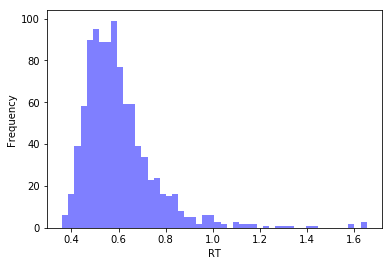

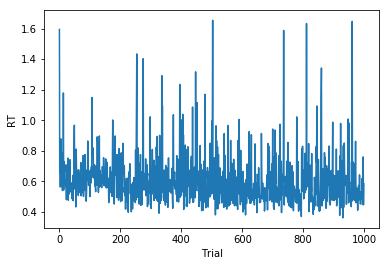

In [7]:
# plot
num_bins = 50
fig = plt.figure()
# the histogram of the data
plot_data = data.rt_raw.tolist()
n, bins, patches = plt.hist(plot_data, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('RT')
plt.ylabel('Frequency')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_hist.png']))

fig = plt.figure()
plt.plot(plot_data)
plt.xlabel('Trial')
plt.ylabel('RT')
fig.savefig("".join([save_dir, 'subj', subj, '_rt.png']))

#%% Get transition data

transitions = [0,9,4,5]
#transitions = [1,2,7,8]
trans_idx = [False]
tmp = data.walk.tolist()
for i,n in enumerate(data.walk.tolist()):
    if i > 0:
        if n in transitions and tmp[i-1] in transitions:
            trans_idx.append(True)
        else:
            trans_idx.append(False)
    
    


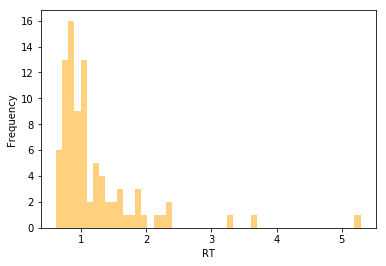

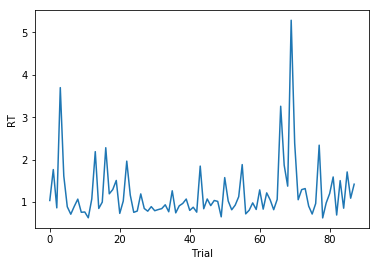

In [6]:
transition_data = data.loc[trans_idx]

# append transition to data
data['transition'] = trans_idx
data['transition'] = data['transition'].astype('category')

# plot
num_bins = 50
fig = plt.figure()
# the histogram of the data
plot_data = transition_data.rt_raw.tolist()
n, bins, patches = plt.hist(plot_data, num_bins, facecolor='orange', alpha=0.5)
plt.xlabel('RT')
plt.ylabel('Frequency')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_hist_trans.png']))

fig = plt.figure()
plt.plot(plot_data)
plt.xlabel('Trial')
plt.ylabel('RT')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_trans.png']))




In [8]:
#%% Not transition data   
within_data = data[data["transition"] == 0]

# plot
num_bins = 50
fig = plt.figure()
# the histogram of the data
plot_data = within_data.rt_raw.tolist()
n, bins, patches = plt.hist(plot_data, num_bins, facecolor='red', alpha=0.5)
plt.xlabel('RT')
plt.ylabel('Frequency')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_hist_within.png']))

fig = plt.figure()
plt.plot(plot_data)
plt.xlabel('Trial')
plt.ylabel('RT')
fig.savefig("".join([save_dir, 'subj', subj, '_rt_within.png']))




KeyError: 'transition'

In [7]:
#%% Stats

print(transition_data.rt_raw.mean())
print(within_data.rt_raw.mean())
print(data.rt_raw.mean())



NameError: name 'transition_data' is not defined

In [8]:
# make predictors for recency and priming, according to karuza paper
# lag10
lag = 10
walk = data.walk.astype(float)
walk = walk.tolist()
# append zeros to the beginning
for i in range(lag):
   walk.insert(0,np.nan)
lag10 = [];
for i,n in enumerate(walk):
    if i > 9:
        curr = walk[(i-10):(i-1)]
        lag10.append(curr.count(n))
    
# recency
walk = data.walk.astype(float)
walk = walk.tolist()
recency = [np.nan]
for i,n in enumerate(walk):
    if i > 0:
        curr = walk[0:(i-1)]
        if n in curr:
            idx = i - max(loc for loc, val in enumerate(curr) if val == n)
        else:
            idx = np.nan
        recency.append(idx)
        


# hand transition index
left = ['q', 'w', 'e', 'r', 'v']
right = ['b', 'u', 'i', 'o', 'p']
hand = []
hand_transition = [False]
for i,key in enumerate(data.resp):
    if key in left:
        hand.append('left')
    elif key in right:
        hand.append('right')
    else:
        hand.append(np.nan)
        
    if i > 0:
        if len(hand) == 0:
            hand_transition.append(False)
        elif hand[i] != hand[i-1]:
            hand_transition.append(True)
        else:
            hand_transition.append(False)
            




In [10]:
#%%
            
import statsmodels.api as sm

data['lag10'] = lag10
data['order'] = (data['order'] + 1) # not taking log
data['recency'] = recency
data['resp'] = data['resp'].astype('category')
data['block'] = data['block'].astype('category')
data['hand'] = hand
data['hand_transition'] = hand_transition
data['hand'] = data['hand'].astype('category')
data['hand_transition'] = data['hand_transition'].astype('category')

# accuracy
print(np.mean(data.correct_raw[data.transition == 1]))
print(np.mean(data.correct_raw[data.transition == 0]))

# cut down to only relevant fields
# get only correct responses
data = data[data.correct_raw == 1]
data = data.dropna(how='any')
# convert to float
data.rt_raw = data.rt_raw.apply(float)
# remove rt's greater than 2 std
data = data.loc[(data.rt_raw < cutoff) ]

model_data = data.dropna(how='any')
#model_data = model_data[model_data.trialNum >600] # if you want to look after they have learned
Y = model_data["rt_raw"]
X = model_data[["transition", "lag10", "recency", "order", "resp", "hand_transition", "block"]]
X = sm.add_constant(X)
X["resp"].cat.categories = [1,2,3,4,5,6,7,8,9,10]
#X["hand"].cat.categories = [1,2]



0.897727272727
0.935307017544


In [11]:
# Note the difference in argument order
model = sm.OLS(Y, X.astype(float)).fit()
predictions = model.predict(X) # make the predictions by the model
model_data.to_csv("".join([save_dir, 'subj', subj, '_clean_data']))

#%% Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rt_raw   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     9.131
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           6.27e-11
Time:                        13:57:10   Log-Likelihood:                -230.87
No. Observations:                 904   AIC:                             477.7
Df Residuals:                     896   BIC:                             516.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0462      0.048     21.584      0.000       0.951       1.141
transition          0.0718      0.038      1.865      0.063      -0.004       0.147
lag10              -0.0493      0.014     -3.620      0.000      -0.076      -0.023
recency             0.0022      0.001      1.542      0.123      -0.001       0.005
order              -0.0003      0.000     -2.309      0.021      -0.001   -5.15e-05
resp               -0.0100      0.004     -2.731      0.006      -0.017      -0.003
hand_transition     0.0385      0.022      1.745      0.081      -0.005       0.082
block               0.0653      0.038      1.729      0.084      -0.009       0.139
==============================================================================
Omnibus:                      291.407   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              867.752
Skew:                           1.609   Prob(JB):                    3.72e-189
Kurtosis:                       6.562   Cond. No.                     2.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
#%% Check for colinearity

#from libraries.settings import *
from scipy.stats.stats import pearsonr
import itertools

correlations = {}
columns = X.columns.tolist()

for col_a, col_b in itertools.combinations(columns, 2):
    correlations[col_a + '__' + col_b] = pearsonr(X.loc[:, col_a], X.loc[:, col_b])

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value'] 

print(result)


                                  PCC        p-value
const__lag10                      NaN   1.000000e+00
recency__hand_transition     0.031187   3.489585e-01
lag10__hand_transition      -0.048822   1.424437e-01
transition__lag10           -0.034440   3.009579e-01
transition__hand_transition  0.257552   3.659782e-15
order__hand_transition       0.065289   4.971520e-02
lag10__resp                 -0.047445   1.540636e-01
const__block                      NaN   1.000000e+00
recency__order              -0.002620   9.373062e-01
lag10__recency              -0.650510  6.998084e-110
transition__order            0.009301   7.800376e-01
const__transition                 NaN   1.000000e+00
resp__hand_transition       -0.049040   1.406655e-01
lag10__order                -0.016781   6.143462e-01
recency__resp                0.031931   3.375715e-01
hand_transition__block       0.053846   1.056841e-01
resp__block                 -0.069064   3.788211e-02
transition__recency          0.002503   9.4008

/Users/stiso/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [12]:
transitions = [0,9,4,5]
#transitions = [1,2,7,8]
trans_idx = [0]
tmp = data.walk.tolist()
for i,n in enumerate(data.walk.tolist()):
    if i > 0:
        if n in transitions and tmp[i-1] in transitions:
            trans_idx.append(1)
        else:
            trans_idx.append(0)

data['transition'] = trans_idx
print(data["transition"])
data.to_csv("".join([save_dir, 'subj', subj, '_trans.csv']))


0       0
1       0
2       0
3       0
4       1
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      1
24      0
25      0
26      0
27      0
28      0
29      0
       ..
973     0
974     0
975     0
976     0
977     0
978     0
979     0
980     1
981     1
982     0
983     0
984     0
985     0
986     0
987     0
988     1
989     0
990     0
991     0
992     0
993     0
994     0
995     0
996     0
997     0
998     0
999     0
1000    0
1001    0
1002    0
Name: transition, Length: 1003, dtype: int64
